In [1]:
#%load_ext jupyter_black

In [2]:
import datetime as dt
import math
import os
import random
import sys
import time

import keras
import numpy as np
import pandas as pd
import sklearn
import talib
import tensorflow as tf
import tensorflow_addons as tfa
import yfinance as yf
from fastai.tabular.core import df_shrink
from matplotlib import pyplot as plt
from trading_modules.create_backtest import (
    VaR,
    average_drawdown,
    average_drawdown_squared,
    beta,
    burke_ratio,
    calmar_ratio,
    classification_report_display,
    conditional_sharpe_ratio,
    confusion_matrix_display,
    cVaR,
    excess_var,
    financial_evaluation,
    gain_loss_ratio,
    hpm,
    information_ratio,
    kappa_three_ratio,
    lpm,
    max_drawdown,
    modigliani_ratio,
    omega_ratio,
    plain_classification_report,
    plot_charts,
    plot_init,
    plot_tables,
    second_2_minute_converter,
    sharpe_ratio,
    sortino_ratio,
    sterling_ratio,
    treynor_ratio,
    upside_potential_ratio,
    volatility,
)
from trading_modules.create_data import (
    CMF,
    HMA,
    adjustPrices,
    create_2d_data,
    create_all_indicators_in_talib,
    create_labels,
    number_null_and_nan,
    one_hot,
    pltcolor,
    reverse_one_hot,
    show_label_distribution,
    show_price_and_labels,
    show_prices,
    trendNormalizePrices,
)
from trading_modules.create_neural_networks import (
    create_model_CNN_2D,
    create_model_GRU,
    create_model_LSTM,
    create_model_MLP,
    model_ho,
    model_train_test,
    show_epoch_and_score,
)
from trading_modules.create_strategy import (
    create_buy_and_hold_predictions,
    create_bollinger_bands_predictions,
    create_ema_crossover_predictions,
    create_random_predictions,
    create_rsi_predictions,
)
from trading_modules.feaure_engineering import feature_selection, scaling
from trading_modules.configurations import shift_predictions

<h1 style="font-size:40px;"> <center> CONSTANTS </center> </h1>

In [9]:
import quantstats as qs


In [30]:
prices = yf.download(
    "AAPL",
    start=START_DATE,
    end=END_DATE,
    interval=INTERVAL,
    progress=False,
    auto_adjust=True,
)

bench = yf.download(
    "SPY",
    start=START_DATE,
    end=END_DATE,
    interval=INTERVAL,
    progress=False,
    auto_adjust=True,
)



In [31]:
prices['date'] = prices.index
prices['date'] = prices['date'].dt.tz_localize(None) 
prices.index = prices['date']

bench['date'] = bench.index
bench['date'] = bench['date'].dt.tz_localize(None) 
bench.index = bench['date']

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2013-01-02  2013-01-02
End Period                 2016-12-30  2016-12-30
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          60.69%      65.95%
CAGR﹪                     12.61%      13.52%

Sharpe                     0.6         1.06
Prob. Sharpe Ratio         88.16%      98.14%
Smart Sharpe               0.58        1.02
Sortino                    0.84        1.5
Smart Sortino              0.81        1.45
Sortino/√2                 0.6         1.06
Smart Sortino/√2           0.57        1.03
Omega                      1.11        1.11

Max Drawdown               -30.44%     -13.02%
Longest DD Days            584         272
Volatility (ann.)          25.15%      12.76%
R^2                        0.23        0.23
Information Ratio          0.0         0.0
Calmar                     0.41        1

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2015-05-26  2016-05-12  2016-12-30   584    -30.443788        -28.611337
2  2013-01-03  2013-04-19  2013-11-27   328    -28.454549        -26.963294
3  2013-12-24  2014-01-30  2014-04-24   121    -12.333146        -12.189303
4  2014-11-28  2015-01-16  2015-02-04    68    -10.932747        -10.714267
5  2015-02-24  2015-03-11  2015-05-22    87     -8.090204         -7.330815

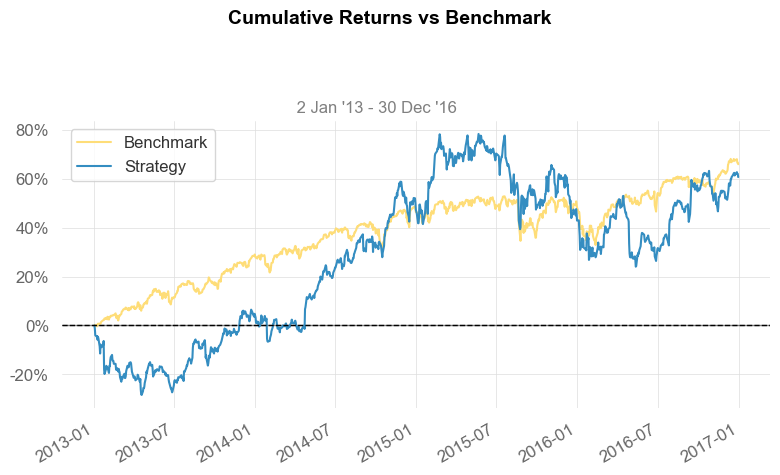

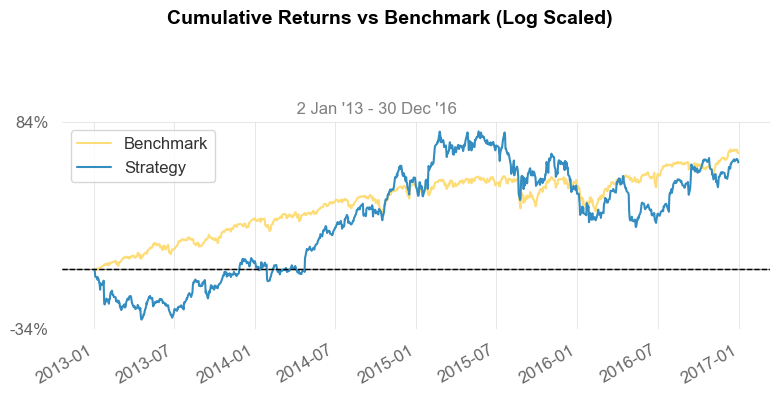

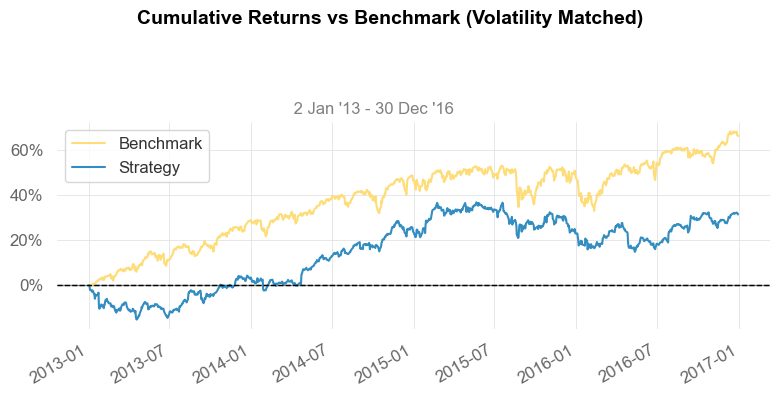

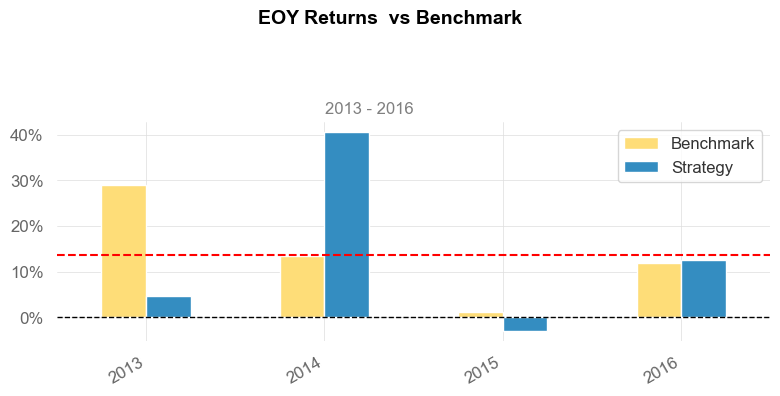

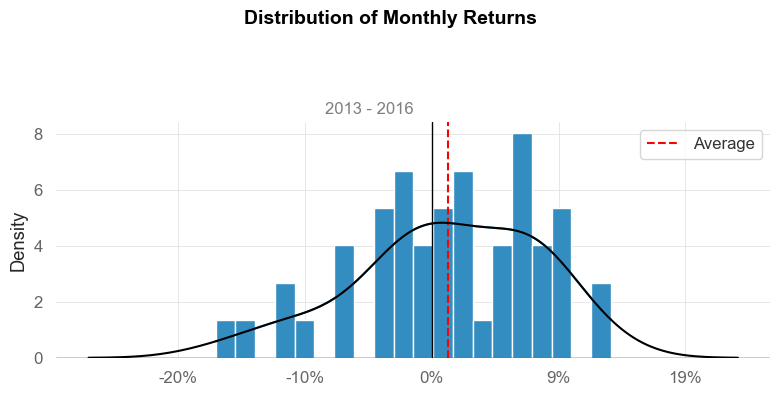

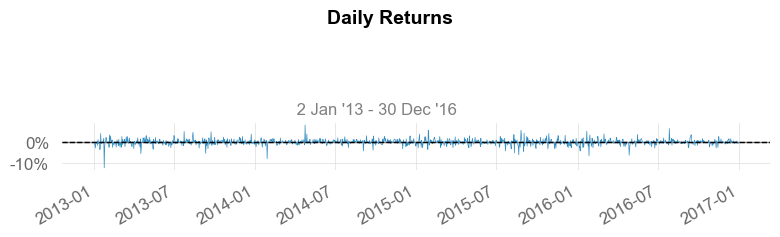

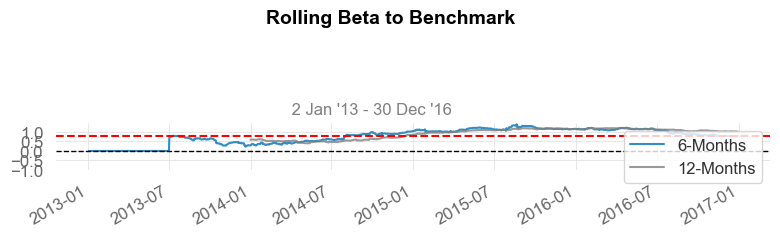

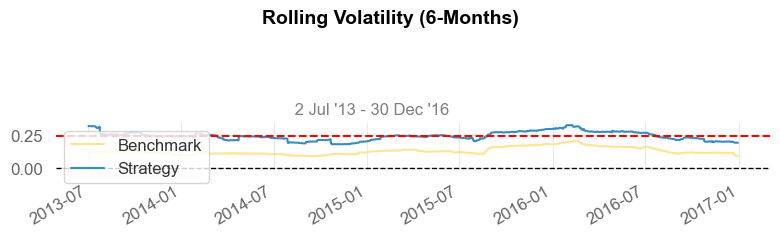

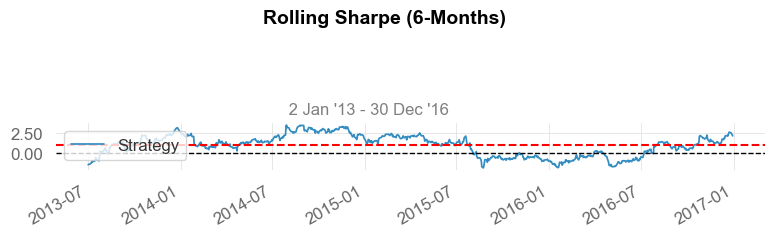

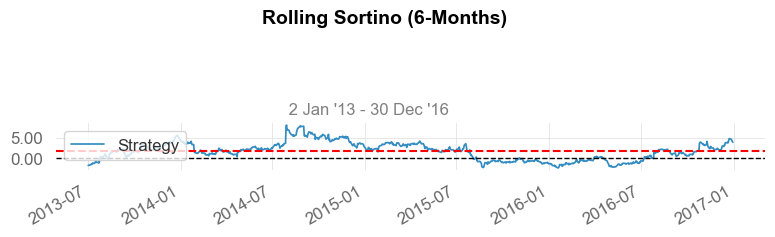

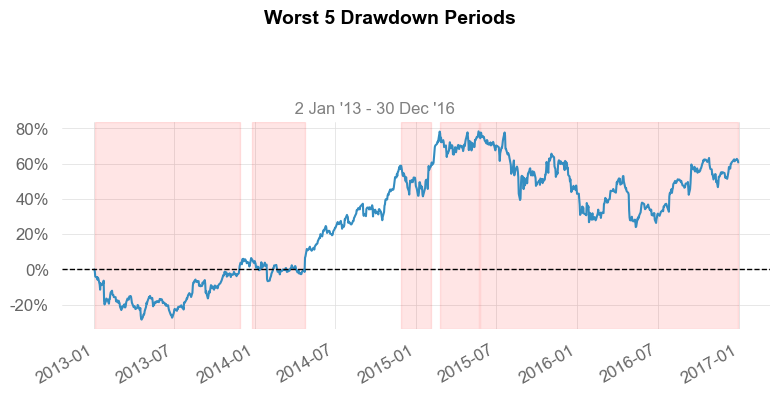

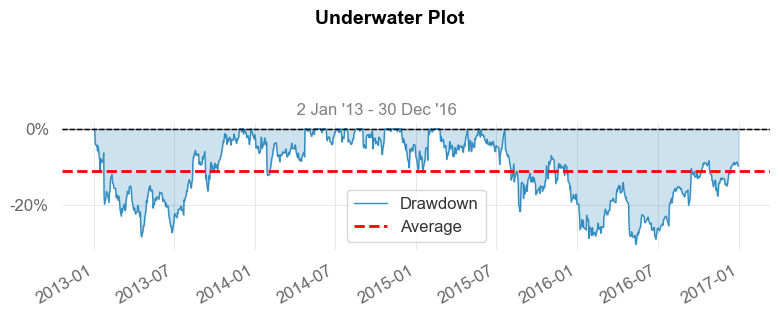

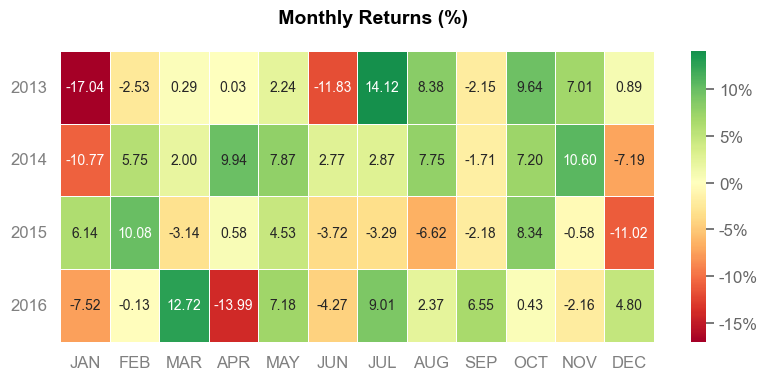

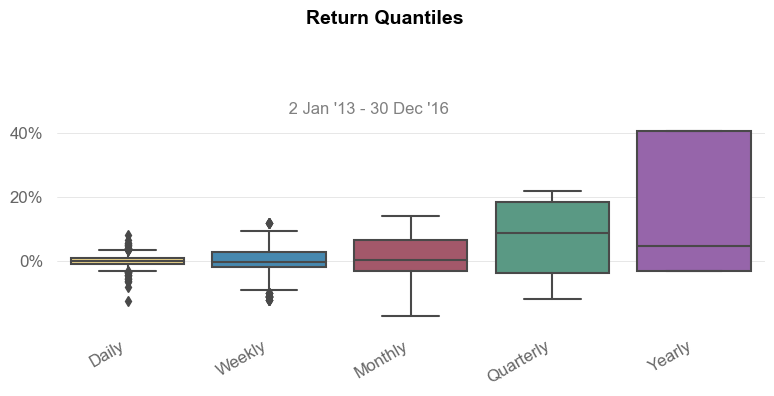

In [34]:
qs.reports.full(
    prices["Close"],
    benchmark=bench['Close'],
)

In [35]:
qs.reports.html(
    prices["Close"],
    benchmark=bench['Close'],
)

In [4]:
SEED = 42
TRAIN_TEST_EPOCH = 20
HO_EPOCH = 10
HO_TRIALS = 10
FINAL_MODEL_EPOCH = 50
EPOCH_BEFORE_OVERFIT = 50
MAX_ROW_AND_COLUMN_2_DISPLAY = 100
LENGTH = 30
METRIC="precision" # precision, recall, f1_score
TICKER = "SPY"
BENCHMARK_TICKER = "SPY"
START_DATE = "2009-05-20"
END_DATE = "2023-01-01"
INTERVAL = "1d"
SEE_ALL_EPOCHS = False
RUN_BUY_AND_HOLD = False
RUN_RANDOM_PREDICTION = False
RUN_RSI = False
RUN_EMA_CROSSOVER = False
RUN_BOLLINGER_BANDS = False
RUN_MLP = True
RUN_LSTM = False
RUN_GRU = False
RUN_CNN = False

In [ ]:
pd.set_option("display.max_rows", MAX_ROW_AND_COLUMN_2_DISPLAY)
pd.set_option("display.max_columns", MAX_ROW_AND_COLUMN_2_DISPLAY)

In [ ]:
notebook_start_time = time.time()

<h1 style="font-size:40px;"> <center> DATA PREPROCESSING </center> </h1>

In [6]:
prices = yf.download(
    TICKER,
    start=START_DATE,
    end=END_DATE,
    interval=INTERVAL,
    progress=False,
    auto_adjust=True,
)
prices

Open        High         Low       Close  \
Date                                                                        
2009-05-20 00:00:00-04:00   70.645337   71.298398   69.462157   69.538986   
2009-05-21 00:00:00-04:00   68.732259   68.993485   67.810300   68.540184   
2009-05-22 00:00:00-04:00   68.732242   69.147126   68.132968   68.394188   
2009-05-26 00:00:00-04:00   67.887119   70.345682   67.856386   70.145927   
2009-05-27 00:00:00-04:00   70.253490   70.491661   68.786031   68.893593   
...                               ...         ...         ...         ...   
2022-12-23 00:00:00-05:00  379.649994  383.059998  378.029999  382.910004   
2022-12-27 00:00:00-05:00  382.790009  383.149994  379.649994  381.399994   
2022-12-28 00:00:00-05:00  381.329987  383.390015  376.420013  376.660004   
2022-12-29 00:00:00-05:00  379.630005  384.350006  379.079987  383.440002   
2022-12-30 00:00:00-05:00  380.640015  382.579987  378.429993  382.429993   

                              Volume  
Date                                  
2009-05-20 00:00:00-04:00  285722200  
2009-05-21 00:00:00-04:00  258988400  
2009-05-22 00:00:00-04:00  166811900  
2009-05-26 00:00:00-04:00  236318500  
2009-05-27 00:00:00-04:00  246015800  
...                              ...  
2022-12-23 00:00:00-05:00   59857300  
2022-12-27 00:00:00-05:00   51638200  
2022-12-28 00:00:00-05:00   70911500  
2022-12-29 00:00:00-05:00   66970900  
2022-12-30 00:00:00-05:00   83975100  

[3429 rows x 5 columns]

In [7]:
print(f"{prices.memory_usage().sum()/(1024**2)} MB is used before df_shrink")
prices = df_shrink(prices, int2uint=True)
print(f"{prices.memory_usage().sum()/(1024**2)} MB is used after df_shrink")

0.28298187255859375 MB is used before df_shrink
0.21757888793945312 MB is used after df_shrink


In [8]:
show_prices(ticker=TICKER, df=prices.iloc[150:, :], desc=f"Close Price of {TICKER}")

<h1 style="font-size:30px;"> <center> Trend Normalize and Visualize </center> </h1>

In [9]:
tn_prices = trendNormalizePrices(prices)
tn_prices

Open      High       Low     Close     Volume
Date                                                                        
2009-07-02 00:00:00-04:00 -0.613209  0.337139 -1.671726 -1.633098  212309900
2009-07-06 00:00:00-04:00 -1.932617 -1.167702 -2.148956 -1.268143  174499600
2009-07-07 00:00:00-04:00 -0.779307 -0.694315 -2.100520 -2.054164  197088900
2009-07-08 00:00:00-04:00 -1.199463 -1.037201 -2.427964 -1.655320  248050500
2009-07-09 00:00:00-04:00 -0.685849 -0.461781 -1.226696 -1.025814  163777600
...                             ...       ...       ...       ...        ...
2022-12-23 00:00:00-05:00 -7.306054 -3.896050 -8.926049 -4.046044   59857300
2022-12-27 00:00:00-05:00 -2.835277 -2.475292 -5.975292 -4.225292   51638200
2022-12-28 00:00:00-05:00 -2.236787 -0.176759 -7.146761 -6.906770   70911500
2022-12-29 00:00:00-05:00 -3.069598  1.650403 -3.619617  0.740399   66970900
2022-12-30 00:00:00-05:00 -0.947872  0.992100 -3.157894  0.842106   83975100

[3399 rows x 5 columns]

In [10]:
show_prices(
    ticker=TICKER, df=tn_prices.iloc[150:, :], desc=f"Close TN-Price of {TICKER}"
)

<h1 style="font-size:30px;"> <center> Adding Technical Indicators </center> </h1>

In [11]:
prices_and_indicators = create_all_indicators_in_talib(
    df=tn_prices, periods=list(range(7, 30))
)

In [12]:
prices_and_indicators.head(5)

Open      High       Low     Close     Volume  \
Date                                                                           
2009-11-02 00:00:00-05:00 -2.497209 -1.503511 -3.312342 -2.349703  254222900   
2009-11-03 00:00:00-05:00 -2.646025 -1.823119 -2.801284 -1.939566  228362600   
2009-11-04 00:00:00-05:00 -1.110674 -0.474085 -1.778307 -1.568704  247996700   
2009-11-05 00:00:00-05:00 -0.968816 -0.021711 -1.139608 -0.044996  180015300   
2009-11-06 00:00:00-05:00 -0.466991  0.418019 -0.630016  0.208409  170954100   

                               RSI-7    WILLR-7    STOCH-7   STOCHF-7  \
Date                                                                    
2009-11-02 00:00:00-05:00  40.234328 -77.278150  20.449063  37.365276   
2009-11-03 00:00:00-05:00  44.006378 -65.324621  16.422115  54.496660   
2009-11-04 00:00:00-05:00  47.501810 -38.566618  27.571866  61.433382   
2009-11-05 00:00:00-05:00  59.592702  -0.707612  43.150261  99.292388   
2009-11-06 00:00:00-05:00  61.321115  -5.619028  57.891451  94.380972   

                              SMA-7     EMA-7     WMA-7     HMA-7    TEMA-7  \
Date                                                                          
2009-11-02 00:00:00-05:00 -1.785734 -1.756268 -2.121476 -2.783653 -2.813545   
2009-11-03 00:00:00-05:00 -2.008537 -1.802093 -2.159934 -2.501421 -2.500667   
2009-11-04 00:00:00-05:00 -2.058841 -1.743746 -2.049976 -1.864136 -2.068756   
2009-11-05 00:00:00-05:00 -1.852543 -1.319058 -1.546515 -0.658873 -0.921864   
2009-11-06 00:00:00-05:00 -1.419917 -0.937192 -1.031277  0.394256 -0.135155   

                                PPO-7       ROC-7      CMO-7    MACD-7  \
Date                                                                     
2009-11-02 00:00:00-05:00  428.603181 -474.831126 -19.531343 -0.956761   
2009-11-03 00:00:00-05:00  461.508260  410.490163 -11.987243 -0.898944   
2009-11-04 00:00:00-05:00  400.845155   28.944341  -4.996381 -0.780092   
2009-11-05 00:00:00-05:00  365.995359  -96.978294  19.185405 -0.438918   
2009-11-06 00:00:00-05:00  260.609043 -107.390454  22.642230 -0.156011   

                             MAMA-7  STOCHRSI-7       DX-7     ADXR-7  \
Date                                                                    
2009-11-02 00:00:00-05:00 -0.824406   76.280447  56.317081  29.355718   
2009-11-03 00:00:00-05:00 -0.877509   93.581793  56.317081  31.465250   
2009-11-04 00:00:00-05:00 -0.910423  100.000000   1.834729  29.757876   
2009-11-05 00:00:00-05:00 -0.869212  100.000000  10.384745  30.274519   
2009-11-06 00:00:00-05:00 -0.715266  100.000000  21.118832  30.553566   

                                CCI-7  PLUS_DI-7  MINUS_DI-7     ATR-7  \
Date                                                                     
2009-11-02 00:00:00-05:00  -79.883115   6.547668   23.430495  1.635512   
2009-11-03 00:00:00-05:00  -42.894099   5.954159   21.306652  1.541606   
2009-11-04 00:00:00-05:00   88.129660  17.729840   18.392589  1.530731   
2009-11-05 00:00:00-05:00  146.614089  19.389406   15.741184  1.533054   
2009-11-06 00:00:00-05:00  126.660185  21.697759   14.131118  1.463765   

                              SAR-7  PLUS_DM-7  AROONOSC-7  MIDPRICE-7  MFI-7  \
Date                                                                            
2009-11-02 00:00:00-05:00  0.592706   0.749615  -85.714286   -1.194031    0.0   
2009-11-03 00:00:00-05:00  0.202201   0.642527  -85.714286   -1.332875    0.0   
2009-11-04 00:00:00-05:00 -0.149253   1.899772  -71.428571   -1.893213    0.0   
2009-11-05 00:00:00-05:00 -3.312342   2.080750   42.857143   -1.667026    0.0   
2009-11-06 00:00:00-05:00 -3.246529   2.223229   57.142857   -1.447161    0.0   

                                ADOSC-7  BBANDS-7     CMF-7       BOP  \
Date                                                                    
2009-11-02 00:00:00-05:00 -2.420652e+08 -1.785734 -0.475428  0.081548   
2009-11-03 00:00:00-05:00 -1.651937e+08 -2.008537 -0.300011  0.7222

<h1 style="font-size:30px;"> <center> Data Labeling </center> </h1>

In [13]:
prices_and_indicators_with_label = create_labels(prices_and_indicators)
prices_and_indicators_with_label.head(5)

Open      High       Low     Close     Volume  \
Date                                                                           
2009-11-10 00:00:00-05:00  1.356316  1.837640  1.092370  1.573685  171899800   
2009-11-11 00:00:00-05:00  1.859871  2.255798  1.324211  1.735664  169466200   
2009-11-12 00:00:00-05:00  1.615217  2.057714  0.644811  0.862180  157144500   
2009-11-13 00:00:00-05:00  1.072606  1.678136  0.637868  1.313268  150963000   
2009-11-16 00:00:00-05:00  1.696259  2.713242  1.649682  2.340607  210922200   

                               RSI-7    WILLR-7    STOCH-7   STOCHF-7  \
Date                                                                    
2009-11-10 00:00:00-05:00  67.763853  -5.563209  88.532484  92.092129   
2009-11-11 00:00:00-05:00  68.752837 -10.285259  94.731764  84.681245   
2009-11-12 00:00:00-05:00  57.629530 -34.545908  86.689035  51.707973   
2009-11-13 00:00:00-05:00  61.392793 -27.758987  82.901037  46.465564   
2009-11-16 00:00:00-05:00  68.764241 -11.145861  83.953384  82.044928   

                              SMA-7     EMA-7     WMA-7     HMA-7    TEMA-7  \
Date                                                                          
2009-11-10 00:00:00-05:00 -0.329419  0.206552  0.422591  2.340831  1.759105   
2009-11-11 00:00:00-05:00  0.254205  0.588830  0.938862  2.444112  2.089369   
2009-11-12 00:00:00-05:00  0.654454  0.657168  1.090856  1.785632  1.694295   
2009-11-13 00:00:00-05:00  1.066165  0.821193  1.255559  1.291699  1.671234   
2009-11-16 00:00:00-05:00  1.406965  1.201047  1.574170  1.689912  2.206753   

                                PPO-7        ROC-7      CMO-7    MACD-7  \
Date                                                                      
2009-11-10 00:00:00-05:00   19.824878  -149.660572  35.527707  0.559099   
2009-11-11 00:00:00-05:00 -227.075166  -173.867407  37.505674  0.751540   
2009-11-12 00:00:00-05:00 -389.504825  -144.452216  15.259060  0.726705   
2009-11-13 00:00:00-05:00 -548.658061  -183.716736  22.785585  0.765021   
2009-11-16 00:00:00-05:00 -944.999209 -5301.836331  37.528483  0.937199   

                             MAMA-7  STOCHRSI-7       DX-7     ADXR-7  \
Date                                                                    
2009-11-10 00:00:00-05:00 -0.284999   87.655936  45.924907  35.970448   
2009-11-11 00:00:00-05:00 -0.188777   83.088633  51.890259  38.560908   
2009-11-12 00:00:00-05:00 -0.138732    0.000000  25.621786  35.013386   
2009-11-13 00:00:00-05:00 -0.069589   28.975574  25.363301  32.564906   
2009-11-16 00:00:00-05:00  0.045182  100.000000  45.035251  32.638068   

                                CCI-7  PLUS_DI-7  MINUS_DI-7     ATR-7  \
Date                                                                     
2009-11-10 00:00:00-05:00  104.852780  29.624687   10.977960  1.384308   
2009-11-11 00:00:00-05:00   89.512727  31.163850    9.870842  1.319634   
2009-11-12 00:00:00-05:00   39.838840  26.444860   15.657487  1.332958   
2009-11-13 00:00:00-05:00   26.166236  23.401079   13.932142  1.291145   
2009-11-16 00:00:00-05:00  133.323396  31.135954   11.799751  1.306692   

                              SAR-7  PLUS_DM-7  AROONOSC-7  MIDPRICE-7  \
Date                                                                     
2009-11-10 00:00:00-05:00 -2.802259   2.870678   71.428571   -0.725412   
2009-11-11 00:00:00-05:00 -2.522433   2.878740  100.000000   -0.272743   
2009-11-12 00:00:00-05:00 -2.140174   2.467492   85.714286    0.238746   
2009-11-13 00:00:00-05:00 -1.788496   2.114993   71.428571    0.558095   
2009-11-16 00:00:00-05:00 -1.464953   2.847957  100.000000    1.041613   

                               MFI-7       ADOSC-7  BBANDS-7     CMF-7  \
Date                                                                     
2009-11-10 00:00:00-05:00   0.000000  8.847991e+07 -0.329419  0.350980   
2009-11-11 00:00:00-05:00   0.000000  9.225077e+07  0.254205  0.346170   
2009-11-12 00:00:00-05:00  67.71

In [14]:
show_label_distribution(prices_and_indicators_with_label)

In [15]:
prices_with_label = create_labels(prices)
show_price_and_labels(
    ticker=TICKER, df=prices_with_label, desc=f"Close Price with Labels of {TICKER}"
)

In [16]:
tn_prices_with_label = create_labels(tn_prices)
show_price_and_labels(
    ticker=TICKER,
    df=tn_prices_with_label,
    desc=f"Close TN-Price with Labels of {TICKER}",
)

<h1 style="font-size:30px;"> <center> Creating Train & Test Data </center> </h1>

In [17]:
prices_and_indicators_with_label.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3302 entries, 2009-11-10 00:00:00-05:00 to 2022-12-21 00:00:00-05:00
Columns: 678 entries, Open to Label
dtypes: float64(676), int64(1), uint32(1)
memory usage: 17.1 MB


In [18]:
datas_1d = []

for i in range(5, 13):
    train = prices_and_indicators_with_label.loc[
        (prices_and_indicators_with_label.index >= f"{2009+i-5}-12")
        & (prices_and_indicators_with_label.index <= f"{2010+i}")
    ]
    test = prices_and_indicators_with_label.loc[
        (prices_and_indicators_with_label.index >= f"{2009+i}-12")
        & (prices_and_indicators_with_label.index <= f"{2010+i+1}")
    ]
    datas_1d.append([train, test])

In [19]:
datas_1d[0][0].head(5)

Open      High       Low     Close     Volume  \
Date                                                                           
2009-12-01 00:00:00-05:00 -0.093279  0.481207 -0.240778  0.201727  159613700   
2009-12-02 00:00:00-05:00 -0.117939  0.448780 -0.397412 -0.141224  132315100   
2009-12-03 00:00:00-05:00 -0.065800  0.423282 -1.043965 -0.974102  167324900   
2009-12-04 00:00:00-05:00 -0.106376  0.312844 -1.503753 -0.750716  274907800   
2009-12-07 00:00:00-05:00 -1.004208 -0.522892 -1.330273 -1.058560  127973800   

                               RSI-7    WILLR-7    STOCH-7   STOCHF-7  \
Date                                                                    
2009-12-01 00:00:00-05:00  46.354683 -43.121123  33.079258  68.818273   
2009-12-02 00:00:00-05:00  42.401727 -52.313205  38.229081  59.864861   
2009-12-03 00:00:00-05:00  34.150455 -69.312775  34.872352  39.402433   
2009-12-04 00:00:00-05:00  37.930011 -60.643148  28.020687  48.704006   
2009-12-07 00:00:00-05:00  34.725535 -64.114271  22.161135  22.428328   

                              SMA-7     EMA-7     WMA-7     HMA-7    TEMA-7  \
Date                                                                          
2009-12-01 00:00:00-05:00  0.340231  0.301686  0.161896 -0.609560 -0.281385   
2009-12-02 00:00:00-05:00  0.283518  0.190958  0.041532 -0.313719 -0.324501   
2009-12-03 00:00:00-05:00 -0.012259 -0.100307 -0.272873 -0.557903 -0.803235   
2009-12-04 00:00:00-05:00 -0.262395 -0.262909 -0.457487 -0.902516 -0.913098   
2009-12-07 00:00:00-05:00 -0.550535 -0.461822 -0.656529 -1.148041 -1.119853   

                                PPO-7       ROC-7      CMO-7    MACD-7  \
Date                                                                     
2009-12-01 00:00:00-05:00  -35.303413  -68.926940  -7.290635 -0.126539   
2009-12-02 00:00:00-05:00  -55.072103 -155.217428 -15.196546 -0.185499   
2009-12-03 00:00:00-05:00 -101.810711 -188.850463 -31.699090 -0.353986   
2009-12-04 00:00:00-05:00 -136.648500 -175.053766 -24.139977 -0.425279   
2009-12-07 00:00:00-05:00 -182.450778 -210.448715 -30.548930 -0.513198   

                             MAMA-7  STOCHRSI-7       DX-7     ADXR-7  \
Date                                                                    
2009-12-01 00:00:00-05:00  0.181647   70.921429  20.213024  27.212206   
2009-12-02 00:00:00-05:00  0.166272   50.072924  23.022675  26.401209   
2009-12-03 00:00:00-05:00  0.003361    1.993070  34.184047  25.172896   
2009-12-04 00:00:00-05:00 -0.104364   30.969240  41.251337  24.624863   
2009-12-07 00:00:00-05:00 -0.149802    4.712139  41.251337  26.829438   

                               CCI-7  PLUS_DI-7  MINUS_DI-7     ATR-7  \
Date                                                                    
2009-12-01 00:00:00-05:00  -8.985134  21.928709   33.039432  1.301167   
2009-12-02 00:00:00-05:00 -22.519012  19.784311   31.618647  1.236170   
2009-12-03 00:00:00-05:00 -54.284656  16.516910   33.674296  1.269181   
2009-12-04 00:00:00-05:00 -49.715966  13.335658   32.063360  1.347384   
2009-12-07 00:00:00-05:00 -87.624013  12.124756   29.151950  1.270240   

                              SAR-7  PLUS_DM-7  AROONOSC-7  MIDPRICE-7  \
Date                                                                     
2009-12-01 00:00:00-05:00  2.077404   1.997304  -57.142857   -0.054920   
2009-12-02 00:00:00-05:00  1.837536   1.711975  -57.142857   -0.054920   
2009-12-03 00:00:00-05:00  1.612061   1.467407  -57.142857   -0.378564   
2009-12-04 00:00:00-05:00  1.400114   1.257777  -42.857143   -0.434405   
2009-12-07 00:00:00-05:00  1.200883   1.078095  -28.571429   -0.719592   

                                MFI-7       ADOSC-7  BBANDS-7     CMF-7  \
Date                                                                      
2009-12-01 00:00:00-05:00  148.998038  1.416856e+08  0.340231  0.281848   
2009-12-02 00:00:00-05:00  179.880634  1.178615e+08  0.283518  0.212325   
2009-12-03 00:00:00-05:00    0.000000  4.9

<h1 style="font-size:30px;"> <center> Feature Selection </center> </h1>

In [20]:
datas_1d[0][0].head(5)

Open      High       Low     Close     Volume  \
Date                                                                           
2009-12-01 00:00:00-05:00 -0.093279  0.481207 -0.240778  0.201727  159613700   
2009-12-02 00:00:00-05:00 -0.117939  0.448780 -0.397412 -0.141224  132315100   
2009-12-03 00:00:00-05:00 -0.065800  0.423282 -1.043965 -0.974102  167324900   
2009-12-04 00:00:00-05:00 -0.106376  0.312844 -1.503753 -0.750716  274907800   
2009-12-07 00:00:00-05:00 -1.004208 -0.522892 -1.330273 -1.058560  127973800   

                               RSI-7    WILLR-7    STOCH-7   STOCHF-7  \
Date                                                                    
2009-12-01 00:00:00-05:00  46.354683 -43.121123  33.079258  68.818273   
2009-12-02 00:00:00-05:00  42.401727 -52.313205  38.229081  59.864861   
2009-12-03 00:00:00-05:00  34.150455 -69.312775  34.872352  39.402433   
2009-12-04 00:00:00-05:00  37.930011 -60.643148  28.020687  48.704006   
2009-12-07 00:00:00-05:00  34.725535 -64.114271  22.161135  22.428328   

                              SMA-7     EMA-7     WMA-7     HMA-7    TEMA-7  \
Date                                                                          
2009-12-01 00:00:00-05:00  0.340231  0.301686  0.161896 -0.609560 -0.281385   
2009-12-02 00:00:00-05:00  0.283518  0.190958  0.041532 -0.313719 -0.324501   
2009-12-03 00:00:00-05:00 -0.012259 -0.100307 -0.272873 -0.557903 -0.803235   
2009-12-04 00:00:00-05:00 -0.262395 -0.262909 -0.457487 -0.902516 -0.913098   
2009-12-07 00:00:00-05:00 -0.550535 -0.461822 -0.656529 -1.148041 -1.119853   

                                PPO-7       ROC-7      CMO-7    MACD-7  \
Date                                                                     
2009-12-01 00:00:00-05:00  -35.303413  -68.926940  -7.290635 -0.126539   
2009-12-02 00:00:00-05:00  -55.072103 -155.217428 -15.196546 -0.185499   
2009-12-03 00:00:00-05:00 -101.810711 -188.850463 -31.699090 -0.353986   
2009-12-04 00:00:00-05:00 -136.648500 -175.053766 -24.139977 -0.425279   
2009-12-07 00:00:00-05:00 -182.450778 -210.448715 -30.548930 -0.513198   

                             MAMA-7  STOCHRSI-7       DX-7     ADXR-7  \
Date                                                                    
2009-12-01 00:00:00-05:00  0.181647   70.921429  20.213024  27.212206   
2009-12-02 00:00:00-05:00  0.166272   50.072924  23.022675  26.401209   
2009-12-03 00:00:00-05:00  0.003361    1.993070  34.184047  25.172896   
2009-12-04 00:00:00-05:00 -0.104364   30.969240  41.251337  24.624863   
2009-12-07 00:00:00-05:00 -0.149802    4.712139  41.251337  26.829438   

                               CCI-7  PLUS_DI-7  MINUS_DI-7     ATR-7  \
Date                                                                    
2009-12-01 00:00:00-05:00  -8.985134  21.928709   33.039432  1.301167   
2009-12-02 00:00:00-05:00 -22.519012  19.784311   31.618647  1.236170   
2009-12-03 00:00:00-05:00 -54.284656  16.516910   33.674296  1.269181   
2009-12-04 00:00:00-05:00 -49.715966  13.335658   32.063360  1.347384   
2009-12-07 00:00:00-05:00 -87.624013  12.124756   29.151950  1.270240   

                              SAR-7  PLUS_DM-7  AROONOSC-7  MIDPRICE-7  \
Date                                                                     
2009-12-01 00:00:00-05:00  2.077404   1.997304  -57.142857   -0.054920   
2009-12-02 00:00:00-05:00  1.837536   1.711975  -57.142857   -0.054920   
2009-12-03 00:00:00-05:00  1.612061   1.467407  -57.142857   -0.378564   
2009-12-04 00:00:00-05:00  1.400114   1.257777  -42.857143   -0.434405   
2009-12-07 00:00:00-05:00  1.200883   1.078095  -28.571429   -0.719592   

                                MFI-7       ADOSC-7  BBANDS-7     CMF-7  \
Date                                                                      
2009-12-01 00:00:00-05:00  148.998038  1.416856e+08  0.340231  0.281848   
2009-12-02 00:00:00-05:00  179.880634  1.178615e+08  0.283518  0.212325   
2009-12-03 00:00:00-05:00    0.000000  4.9

In [21]:
datas_1d, selected_features = feature_selection(datas_1d)

In [22]:
print(selected_features)

['RSI-7', 'WILLR-7', 'STOCHF-7', 'CMO-7', 'CCI-7', 'RSI-8', 'WILLR-8', 'STOCHF-8', 'CMO-8', 'RSI-9', 'STOCHF-9', 'CMO-9', 'RSI-10', 'STOCHF-10', 'CMO-10', 'RSI-11', 'STOCHF-11', 'CMO-11', 'RSI-12', 'CMO-12', 'RSI-13', 'CMO-13', 'RSI-14', 'CMO-14', 'RSI-15', 'CMO-15', 'RSI-16', 'CMO-16', 'RSI-17', 'CMO-17']


In [23]:
datas_1d[0][0].head(5)

RSI-7    WILLR-7   STOCHF-7      CMO-7  \
Date                                                                    
2009-12-01 00:00:00-05:00  46.354683 -43.121124  68.818275  -7.290635   
2009-12-02 00:00:00-05:00  42.401726 -52.313206  59.864861 -15.196546   
2009-12-03 00:00:00-05:00  34.150455 -69.312775  39.402431 -31.699089   
2009-12-04 00:00:00-05:00  37.930012 -60.643147  48.704006 -24.139977   
2009-12-07 00:00:00-05:00  34.725536 -64.114273  22.428328 -30.548929   

                               RSI-8    WILLR-8   STOCHF-8      CMO-8  \
Date                                                                    
2009-12-01 00:00:00-05:00  46.891689 -43.121124  56.878876  -6.216620   
2009-12-02 00:00:00-05:00  43.467148 -52.313206  57.696690 -13.065704   
2009-12-03 00:00:00-05:00  36.141388 -74.636749  31.840414 -27.717224   
2009-12-04 00:00:00-05:00  39.278301 -62.068565  48.704006 -21.443399   
2009-12-07 00:00:00-05:00  36.457726 -71.001373  35.885727 -27.084551   

                               RSI-9    WILLR-9   STOCHF-9      CMO-9  \
Date                                                                    
2009-12-01 00:00:00-05:00  47.406174 -46.016094  56.878876  -5.187650   
2009-12-02 00:00:00-05:00  44.385944 -52.313206  47.686794 -11.228110   
2009-12-03 00:00:00-05:00  37.805416 -74.636749  30.687225 -24.389172   
2009-12-04 00:00:00-05:00  40.468529 -68.649353  39.356853 -19.062944   
2009-12-07 00:00:00-05:00  37.949303 -72.051636  35.885727 -24.101391   

                              RSI-10  STOCHF-10     CMO-10     RSI-11  \
Date                                                                    
2009-12-01 00:00:00-05:00  47.858101  56.878876  -4.283800  48.241364   
2009-12-02 00:00:00-05:00  45.157742  47.686794  -9.684516  45.800251   
2009-12-03 00:00:00-05:00  39.190742  25.363247 -21.618519  40.346275   
2009-12-04 00:00:00-05:00  41.494583  37.931435 -17.010836  42.370945   
2009-12-07 00:00:00-05:00  39.219410  28.998627 -21.561184  40.297642   

                           STOCHF-11     CMO-11  STOCHRSI-18  STOCHRSI-19  \
Date                                                                        
2009-12-01 00:00:00-05:00  53.983906  -3.517274    53.918983    53.518867   
2009-12-02 00:00:00-05:00  47.686794  -8.399496    33.507259    33.112278   
2009-12-03 00:00:00-05:00  25.363247 -19.307451     0.000000     0.000000   
2009-12-04 00:00:00-05:00  31.350647 -15.258108    22.266977    22.010572   
2009-12-07 00:00:00-05:00  27.948362 -19.404713     0.000000     0.000000   

                           STOCHRSI-20  STOCHRSI-21  STOCHRSI-22  STOCHRSI-23  \
Date                                                                            
2009-12-01 00:00:00-05:00    53.162983    52.846355    52.555988    52.292572   
2009-12-02 00:00:00-05:00    32.761246    32.449177    32.163025    31.903551   
2009-12-03 00:00:00-05:00     0.000000     0.000000     0.000000     0.000000   
2009-12-04 00:00:00-05:00    21.781368    21.575962    21.388384    21.217794   
2009-12-07 00:00:00-05:00     0.000000     0.000000     0.000000     0.000000   

                           STOCHRSI-24  STOCHRSI-25  STOCHRSI-26  STOCHRSI-27  \
Date                                                                            
2009-12-01 00:00:00-05:00    52.056023    51.845821    51.647575    51.471043   
2009-12-02 00:00:00-05:00    31.670630    31.463743    31.268532    31.094799   
2009-12-03 00:00:00-05:00     0.000000     0.000000     0.000000     0.000000   
2009-12-04 00:00:00-05:00    21.063185    20.923578    20.793240    20.675066   
2009-12-07 00:00:00-05:00     0.000000     0.000000     0.000000     0.000000   

                           STOCHRSI-28  STOCHRSI-29  Label  
Date                                                        
2009-12-01 00:00:00-05:00    51.324596    51.185383      0  
2009-12-02 00:00:00-05:00    30.950836    30.813896      0  
2009-12-03 00:00:00-05:00     0.000000     0.000000      0  
20

<h1 style="font-size:30px;"> <center> Feature Scaling </center> </h1>

In [24]:
datas_1d = scaling(datas_1d)

In [25]:
datas_1d[0][0].head(5)

RSI-7   WILLR-7  STOCHF-7     CMO-7     RSI-8  \
Date                                                                          
2009-12-01 00:00:00-05:00  0.547152 -0.431211  0.688183 -0.104322  0.570560   
2009-12-02 00:00:00-05:00  0.500493 -0.523132  0.598649 -0.217448  0.528891   
2009-12-03 00:00:00-05:00  0.403098 -0.693128  0.394024 -0.453583  0.439754   
2009-12-04 00:00:00-05:00  0.447711 -0.606431  0.487040 -0.345419  0.477923   
2009-12-07 00:00:00-05:00  0.409886 -0.641143  0.224283 -0.437125  0.443603   

                            WILLR-8  STOCHF-8     CMO-8     RSI-9   WILLR-9  \
Date                                                                          
2009-12-01 00:00:00-05:00 -0.431211  0.568789 -0.096575  0.593245 -0.460161   
2009-12-02 00:00:00-05:00 -0.523132  0.576967 -0.202976  0.555449 -0.523132   
2009-12-03 00:00:00-05:00 -0.746367  0.318404 -0.430587  0.473100 -0.746367   
2009-12-04 00:00:00-05:00 -0.620686  0.487040 -0.333123  0.506426 -0.686494   
2009-12-07 00:00:00-05:00 -0.710014  0.358857 -0.420758  0.474901 -0.720516   

                           STOCHF-9     CMO-9    RSI-10  STOCHF-10    CMO-10  \
Date                                                                           
2009-12-01 00:00:00-05:00  0.568789 -0.086721  0.614678   0.568789 -0.076547   
2009-12-02 00:00:00-05:00  0.476868 -0.187698  0.579995   0.476868 -0.173052   
2009-12-03 00:00:00-05:00  0.306872 -0.407709  0.503357   0.253632 -0.386300   
2009-12-04 00:00:00-05:00  0.393569 -0.318672  0.532947   0.379314 -0.303966   
2009-12-07 00:00:00-05:00  0.358857 -0.402899  0.503725   0.289986 -0.385276   

                             RSI-11  STOCHF-11    CMO-11  STOCHRSI-18  \
Date                                                                    
2009-12-01 00:00:00-05:00  0.634722   0.539839 -0.064872     0.539190   
2009-12-02 00:00:00-05:00  0.602604   0.476868 -0.154918     0.335073   
2009-12-03 00:00:00-05:00  0.530844   0.253632 -0.356101     0.000000   
2009-12-04 00:00:00-05:00  0.557484   0.313506 -0.281416     0.222670   
2009-12-07 00:00:00-05:00  0.530205   0.279484 -0.357895     0.000000   

                           STOCHRSI-19  STOCHRSI-20  STOCHRSI-21  STOCHRSI-22  \
Date                                                                            
2009-12-01 00:00:00-05:00     0.535189     0.531630     0.528464     0.525560   
2009-12-02 00:00:00-05:00     0.331123     0.327612     0.324492     0.321630   
2009-12-03 00:00:00-05:00     0.000000     0.000000     0.000000     0.000000   
2009-12-04 00:00:00-05:00     0.220106     0.217814     0.215760     0.213884   
2009-12-07 00:00:00-05:00     0.000000     0.000000     0.000000     0.000000   

                           STOCHRSI-23  STOCHRSI-24  STOCHRSI-25  STOCHRSI-26  \
Date                                                                            
2009-12-01 00:00:00-05:00     0.522926     0.520560     0.518458     0.516476   
2009-12-02 00:00:00-05:00     0.319036     0.316706     0.314637     0.312685   
2009-12-03 00:00:00-05:00     0.000000     0.000000     0.000000     0.000000   
2009-12-04 00:00:00-05:00     0.212178     0.210632     0.209236     0.207932   
2009-12-07 00:00:00-05:00     0.000000     0.000000     0.000000     0.000000   

                           STOCHRSI-27  STOCHRSI-28  STOCHRSI-29  Label  
Date                                                                     
2009-12-01 00:00:00-05:00     0.514710     0.513246     0.511854    0.0  
2009-12-02 00:00:00-05:00     0.310948     0.309508     0.308139    0.0  
2009-12-03 00:00:00-05:00     0.000000     0.000000     0.000000    0.0  
2009-12-04 00:00:00-05:00     0.206751     0.205715     0.204740    0.0  
2009-12-07 00:00:00-05:00     0.000000     0.000000     0.000000    0.0

In [26]:
datas_1d[0][1].head(5)

RSI-7   WILLR-7  STOCHF-7     CMO-7     RSI-8  \
Date                                                                          
2014-12-01 00:00:00-05:00  0.275301 -0.758066  0.172901 -0.763429  0.303921   
2014-12-02 00:00:00-05:00  0.516307 -0.326264  0.829515 -0.179105  0.514668   
2014-12-03 00:00:00-05:00  0.599855 -0.094491  0.905509  0.023459  0.591140   
2014-12-04 00:00:00-05:00  0.580596 -0.206742  0.793258 -0.023236  0.574965   
2014-12-05 00:00:00-05:00  0.625070 -0.149991  0.850009  0.084592  0.615187   

                            WILLR-8  STOCHF-8     CMO-8     RSI-9   WILLR-9  \
Date                                                                          
2014-12-01 00:00:00-05:00 -0.758066  0.140431 -0.777436  0.334516 -0.779928   
2014-12-02 00:00:00-05:00 -0.287737  0.829515 -0.239296  0.519777 -0.287737   
2014-12-03 00:00:00-05:00 -0.094491  0.905509 -0.044025  0.589482 -0.083496   
2014-12-04 00:00:00-05:00 -0.206742  0.793258 -0.085326  0.575541 -0.206742   
2014-12-05 00:00:00-05:00 -0.149991  0.850009  0.017380  0.611919 -0.149991   

                           STOCHF-9     CMO-9    RSI-10  STOCHF-10    CMO-10  \
Date                                                                           
2014-12-01 00:00:00-05:00  0.241934 -0.777961  0.365604   0.241934 -0.769598   
2014-12-02 00:00:00-05:00  0.673736 -0.283003  0.529589   0.712263 -0.313309   
2014-12-03 00:00:00-05:00  0.905509 -0.096775  0.593098   0.905509 -0.136593   
2014-12-04 00:00:00-05:00  0.793258 -0.134020  0.580827   0.793258 -0.170739   
2014-12-05 00:00:00-05:00  0.850009 -0.036829  0.613790   0.850009 -0.079018   

                             RSI-11  STOCHF-11    CMO-11  STOCHRSI-18  \
Date                                                                    
2014-12-01 00:00:00-05:00  0.396120   0.220072 -0.733813     0.000000   
2014-12-02 00:00:00-05:00  0.542413   0.712263 -0.323669     1.000000   
2014-12-03 00:00:00-05:00  0.600402   0.916504 -0.161091     1.000000   
2014-12-04 00:00:00-05:00  0.589414   0.793258 -0.191896     0.942587   
2014-12-05 00:00:00-05:00  0.619386   0.850009 -0.107868     1.000000   

                           STOCHRSI-19  STOCHRSI-20  STOCHRSI-21  STOCHRSI-22  \
Date                                                                            
2014-12-01 00:00:00-05:00     0.000000     0.000000     0.000000     0.000000   
2014-12-02 00:00:00-05:00     1.000000     1.000000     1.000000     1.000000   
2014-12-03 00:00:00-05:00     1.000000     1.000000     1.000000     1.000000   
2014-12-04 00:00:00-05:00     0.942001     0.941444     0.940917     0.940422   
2014-12-05 00:00:00-05:00     1.000000     1.000000     1.000000     1.000000   

                           STOCHRSI-23  STOCHRSI-24  STOCHRSI-25  STOCHRSI-26  \
Date                                                                            
2014-12-01 00:00:00-05:00     0.000000     0.000000     0.000000     0.000000   
2014-12-02 00:00:00-05:00     1.000000     1.000000     1.000000     1.000000   
2014-12-03 00:00:00-05:00     1.000000     1.000000     1.000000     1.000000   
2014-12-04 00:00:00-05:00     0.939957     0.939521     0.939113     0.938731   
2014-12-05 00:00:00-05:00     1.000000     1.000000     1.000000     1.000000   

                           STOCHRSI-27  STOCHRSI-28  STOCHRSI-29  Label  
Date                                                                     
2014-12-01 00:00:00-05:00     0.000000     0.000000     0.000000    1.0  
2014-12-02 00:00:00-05:00     1.000000     1.000000     1.000000    0.0  
2014-12-03 00:00:00-05:00     1.000000     1.000000     1.000000    0.0  
2014-12-04 00:00:00-05:00     0.938373     0.938037     0.937722    0.0  
2014-12-05 00:00:00-05:00     1.000000     1.000000     1.000000    2.0

<h1 style="font-size:30px;"> <center> Controling Null Values </center> </h1>

In [27]:
total_na_count = 0
for data in datas_1d:
    total_na_count += number_null_and_nan(data[0])
    total_na_count += number_null_and_nan(data[1])
print(f"Total null and nan values = {total_na_count}")

Total null and nan values = 0


In [28]:
test_indices = []
for data in datas_1d:
    test_indices.extend(data[1][29:].index)

<h1 style="font-size:40px;"> <center> OTHER STRATEGIES </center> </h1>

<h1 style="font-size:30px;"> Buy & Hold </h1>

In [29]:
if RUN_BUY_AND_HOLD:
    buy_and_hold_prediction = create_buy_and_hold_predictions(len(test_indices))
    buy_and_hold_prediction

<h1 style="font-size:30px;"> Random Trades </h1>

In [30]:
if RUN_RANDOM_PREDICTION:
    random_prediction = create_random_predictions(prices.loc[test_indices])
    random_prediction

<h1 style="font-size:30px;"> RSI </h1>

In [31]:
if RUN_RSI:
    rsi_prediction = create_rsi_predictions(
        prices_and_indicators.loc[test_indices], period=14, buy_value=40, sell_value=60
    )
    rsi_prediction

<h1 style="font-size:30px;"> EMA Cross-over </h1>

In [32]:
if RUN_EMA_CROSSOVER:
    ema_crossover_prediction = create_ema_crossover_predictions(
        prices_and_indicators.loc[test_indices]
    )
    ema_crossover_prediction

<h1 style="font-size:30px;"> Bollinger Bands </h1>

In [33]:
if RUN_BOLLINGER_BANDS:
    bollinger_bands_prediction = create_bollinger_bands_predictions(
        prices.loc[test_indices]
    )
    bollinger_bands_prediction

<h1 style="font-size:40px;"> <center> INITIAL MODELS </center> </h1>

<h1 style="font-size:30px;"> Matrix Data Creation </h1>

In [34]:
datas_2d = create_2d_data(datas_1d, LENGTH)

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [35]:
if RUN_MLP:
    results = model_train_test("MLP", datas_1d, epochs=TRAIN_TEST_EPOCH, metric=METRIC)
    print(f"\nMean {METRIC} score: {results[1]}\n")
    print(f"Completed in {results[2]} minutes")
    history = results[3]
    show_epoch_and_score(
        history,
        [
            "loss",
            f"{METRIC}",
        ],
    )

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
8/8 [==============================] - 0s 4ms/step

Mean precision score: 0.5050771581501818

Completed in 0.87 minutes


<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

In [36]:
if RUN_LSTM:  
    results = model_train_test("LSTM", datas_2d, epochs=TRAIN_TEST_EPOCH)
    print(f"\nMean f1-macro score: {results[1]}\n")
    print(f"Completed in {results[2]} minutes")
    history = results[3]
    show_epoch_and_score(
        history,
        [
            "loss",
            "f1_score",
        ],
    )

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

In [37]:
if RUN_GRU:     
    results = model_train_test("GRU", datas_2d, epochs=TRAIN_TEST_EPOCH)
    print(f"\nMean f1-macro score: {results[1]}\n")
    print(f"Completed in {results[2]} minutes")
    history = results[3]
    show_epoch_and_score(
        history,
        [
            "loss",
            "f1_score",
        ],
    )

<h1 style="font-size:30px;"> <center> CNN </center> </h1>

In [38]:
if RUN_CNN:  
    results = model_train_test("CNN_2D", datas_2d, epochs=TRAIN_TEST_EPOCH)
    print(f"\nMean f1-macro score: {results[1]}\n")
    print(f"Completed in {results[2]} minutes")
    history = results[3]
    show_epoch_and_score(
        history,
        [
            "loss",
            "f1_score",
        ],
    )

<h1 style="font-size:40px;"> <center> HYPERPARAMETER TUNING </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [39]:
if RUN_MLP:
    mlp_parameter_space = {
        "activation_func": ["relu", "selu", "swish"],
        "dropout_rate": [0.1, 0.2, 0.3],
        "optimizer_algo": ["adam", "adadelta", "rmsprop"],
        "batch_size": [32, 64, 256],
    }
    best_mlp_parameters = model_ho(
        "MLP",
        datas_1d,
        epochs=HO_EPOCH,
        parameter_space=mlp_parameter_space,
        metric=METRIC,
        trial_number=HO_TRIALS
    )

[I 2023-02-21 16:21:11,684] A new study created in memory with name: MLP_Bayesian_Optimization


12/12 [==============================] - 0s 2ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



12/12 [==============================] - 0s 2ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



12/12 [==============================] - 0s 3ms/step


[I 2023-02-21 16:21:40,990] Trial 0 finished with value: 0.26958563235682315 and parameters: {'activation_func': 'selu', 'dropout_rate': 0.1, 'optimizer_algo': 'adadelta', 'batch_size': 256}. Best is trial 0 with value: 0.26958563235682315.


12/12 [==============================] - 0s 2ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



12/12 [==============================] - 0s 2ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



12/12 [==============================] - 0s 2ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



12/12 [==============================] - 0s 2ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2023-02-21 16:22:08,587] Trial 1 finished with value: 0.4818000021466297 and parameters: {'activation_func': 'relu', 'dropout_rate': 0.3, 'optimizer_algo': 'rmsprop', 'batch_size': 256}. Best is trial 1 with value: 0.4818000021466297.


12/12 [==============================] - 0s 3ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



12/12 [==============================] - 0s 2ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



12/12 [==============================] - 0s 2ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



12/12 [==============================] - 0s 2ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



12/12 [==============================] - 0s 2ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2023-02-21 16:22:40,451] Trial 2 finished with value: 0.4988697871469284 and parameters: {'activation_func': 'selu', 'dropout_rate': 0.2, 'optimizer_algo': 'adam', 'batch_size': 64}. Best is trial 2 with value: 0.4988697871469284.


12/12 [==============================] - 0s 2ms/step


[I 2023-02-21 16:23:17,073] Trial 3 finished with value: 0.330678201303662 and parameters: {'activation_func': 'swish', 'dropout_rate': 0.3, 'optimizer_algo': 'adadelta', 'batch_size': 32}. Best is trial 2 with value: 0.4988697871469284.


12/12 [==============================] - 0s 2ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



12/12 [==============================] - 0s 2ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



12/12 [==============================] - 0s 2ms/step


[I 2023-02-21 16:23:47,322] Trial 4 finished with value: 0.32460246903254614 and parameters: {'activation_func': 'swish', 'dropout_rate': 0.2, 'optimizer_algo': 'adadelta', 'batch_size': 256}. Best is trial 2 with value: 0.4988697871469284.


12/12 [==============================] - 0s 3ms/step


[I 2023-02-21 16:24:20,633] Trial 5 finished with value: 0.330678201303662 and parameters: {'activation_func': 'swish', 'dropout_rate': 0.3, 'optimizer_algo': 'adadelta', 'batch_size': 32}. Best is trial 2 with value: 0.4988697871469284.


12/12 [==============================] - 0s 2ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



12/12 [==============================] - 0s 2ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



12/12 [==============================] - 0s 2ms/step


[I 2023-02-21 16:24:52,208] Trial 6 finished with value: 0.5203303527387197 and parameters: {'activation_func': 'selu', 'dropout_rate': 0.2, 'optimizer_algo': 'rmsprop', 'batch_size': 32}. Best is trial 6 with value: 0.5203303527387197.


12/12 [==============================] - 0s 3ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



12/12 [==============================] - 0s 2ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



12/12 [==============================] - 0s 2ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



12/12 [==============================] - 0s 3ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



12/12 [==============================] - 0s 2ms/step


[I 2023-02-21 16:25:23,459] Trial 7 finished with value: 0.5183036119804008 and parameters: {'activation_func': 'swish', 'dropout_rate': 0.2, 'optimizer_algo': 'rmsprop', 'batch_size': 64}. Best is trial 6 with value: 0.5203303527387197.


12/12 [==============================] - 0s 2ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



12/12 [==============================] - 0s 2ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



12/12 [==============================] - 0s 2ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



12/12 [==============================] - 0s 2ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2023-02-21 16:25:50,977] Trial 8 finished with value: 0.4818000021466297 and parameters: {'activation_func': 'relu', 'dropout_rate': 0.3, 'optimizer_algo': 'rmsprop', 'batch_size': 256}. Best is trial 6 with value: 0.5203303527387197.


12/12 [==============================] - 0s 2ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



12/12 [==============================] - 0s 2ms/step


[I 2023-02-21 16:26:25,582] Trial 9 finished with value: 0.2885533923311917 and parameters: {'activation_func': 'swish', 'dropout_rate': 0.2, 'optimizer_algo': 'adadelta', 'batch_size': 64}. Best is trial 6 with value: 0.5203303527387197.



------------------------------------------
Best precision: 0.5203303527387197
Best hyperparameters: {'activation_func': 'selu', 'dropout_rate': 0.2, 'optimizer_algo': 'rmsprop', 'batch_size': 32}

Completed in 5.22 minutes


<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

In [40]:
if RUN_LSTM:
    lstm_parameter_space = {
        "activation_func": ["tanh", "swish"],
        "dropout_rate": [0.2, 0.3, 0.4],
        "optimizer_algo": ["adam", "adadelta", "rmsprop"],
        "batch_size": [32, 64, 256],
    }
    best_lstm_parameters = model_ho(
        "LSTM",
        datas_2d,
        epochs=HO_EPOCH,
        parameter_space=lstm_parameter_space,
        trial_number=HO_TRIALS,
    )

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

In [41]:
if RUN_GRU:
    gru_parameter_space = {
        "activation_func": ["tanh", "swish"],
        "dropout_rate": [0.2, 0.3, 0.4],
        "optimizer_algo": ["adam", "adadelta", "rmsprop"],
        "batch_size": [32, 64, 256],
    }
    best_gru_parameters = model_ho(
        "GRU",
        datas_2d,
        epochs=HO_EPOCH,
        parameter_space=gru_parameter_space,
        trial_number=HO_TRIALS,
    )

<h1 style="font-size:30px;"> <center> CNN </center> </h1>

In [42]:
if RUN_CNN:
    cnn2d_parameter_space = {
        "activation_func": ["relu", "selu", "swish"],
        "dropout_rate": [0.3, 0.4, 0.5],
        "optimizer_algo": ["adam", "adadelta", "rmsprop"],
        "batch_size": [32, 64, 256],
    }
    best_cnn2d_parameters = model_ho(
        "CNN_2D",
        datas_2d,
        epochs=HO_EPOCH,
        parameter_space=cnn2d_parameter_space,
        trial_number=HO_TRIALS,
    )

<h1 style="font-size:40px;"> <center> FINAL MODEL CREATION </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [109]:
if RUN_MLP:
    if SEE_ALL_EPOCHS:
        results = model_train_test(
            "MLP",
            datas_1d,
            epochs=FINAL_MODEL_EPOCH, parameters=best_mlp_parameters, metric=METRIC
        )
        history = results[3]
        show_epoch_and_score(
            history,
            [
                "loss",
                f"{METRIC}",
            ],
        )
    mlp_predictions = model_train_test(
        "MLP",
        datas_1d,
        epochs=EPOCH_BEFORE_OVERFIT, parameters=best_mlp_parameters, metric=METRIC
    )[0]
    mlp_prediction = np.concatenate(mlp_predictions)
    mlp_prediction = shift_predictions(mlp_prediction)
    mlp_prediction

8/8 [==============================] - 0s 2ms/step


C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



8/8 [==============================] - 0s 2ms/step


<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

In [110]:
if RUN_LSTM:
    results = model_train_test(
        "LSTM", datas_2d, epochs=FINAL_MODEL_EPOCH, parameters=best_lstm_parameters
    )
    history = results[3]
    show_epoch_and_score(
        history,
        [
            "loss",
            "f1_score",
        ],
    )
    lstm_predictions = model_train_test(
        "LSTM", datas_2d, epochs=EPOCH_BEFORE_OVERFIT, parameters=best_lstm_parameters
    )[0]
    lstm_prediction = np.concatenate(lstm_predictions)
    lstm_prediction = shift_predictions(lstm_prediction)
    lstm_prediction

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

In [111]:
if RUN_GRU:
    results = model_train_test(
        "GRU", datas_2d, epochs=FINAL_MODEL_EPOCH, parameters=best_gru_parameters
    )
    history = results[3]
    show_epoch_and_score(
        history,
        [
            "loss",
            "f1_score",
        ],
    )
    gru_predictions = model_train_test(
        "GRU", datas_2d, epochs=EPOCH_BEFORE_OVERFIT, parameters=best_gru_parameters
    )[0]
    gru_prediction = np.concatenate(gru_predictions)
    gru_prediction = shift_predictions(gru_prediction)
    gru_prediction

<h1 style="font-size:30px;"> <center> CNN-2D </center> </h1>

In [112]:
if RUN_CNN:
    results = model_train_test(
        "CNN_2D",
        datas_2d,
        epochs=FINAL_MODEL_EPOCH,
        parameters=best_cnn2d_parameters,
    )
    history = results[3]
    show_epoch_and_score(
        history,
        [
            "loss",
            "f1_score",
        ],
    )
    cnn2d_predictions = model_train_test(
        "CNN_2D", datas_2d, epochs=EPOCH_BEFORE_OVERFIT, parameters=best_cnn2d_parameters
    )[0]
    cnn2d_prediction = np.concatenate(cnn2d_predictions)
    cnn2d_prediction = shift_predictions(cnn2d_prediction)
    cnn2d_prediction

<h1 style="font-size:40px;"> <center> CLASSIFICATION EVALUATION </center> </h1>

In [113]:
test_labels = prices_and_indicators_with_label.loc[test_indices]
test_labels.head(5)

Open      High       Low     Close     Volume  \
Date                                                                           
2015-01-13 00:00:00-05:00  0.090134  1.264984 -3.028427 -1.672150  214553300   
2015-01-14 00:00:00-05:00 -3.396784 -2.144159 -4.329736 -2.351496  192991100   
2015-01-15 00:00:00-05:00 -1.207339 -0.879077 -3.582965 -3.462024  176613900   
2015-01-16 00:00:00-05:00 -3.569484 -0.934688 -3.759532 -1.098827  211879600   
2015-01-20 00:00:00-05:00 -0.387711 -0.111268 -2.314134 -0.681428  130991100   

                               RSI-7    WILLR-7    STOCH-7   STOCHF-7  \
Date                                                                    
2015-01-13 00:00:00-05:00  43.234200 -52.852864  44.837861  28.193096   
2015-01-14 00:00:00-05:00  39.825098 -63.246979  35.890284  32.366605   
2015-01-15 00:00:00-05:00  34.618997 -85.803085  27.507766  14.196915   
2015-01-16 00:00:00-05:00  50.638839 -47.138097  30.527948  57.749262   
2015-01-20 00:00:00-05:00  53.011294 -40.308908  39.640408  65.209845   

                              SMA-7     EMA-7     WMA-7     HMA-7    TEMA-7  \
Date                                                                          
2015-01-13 00:00:00-05:00 -1.444704 -0.881910 -1.080510 -1.020524 -1.453780   
2015-01-14 00:00:00-05:00 -1.369190 -1.249306 -1.307208 -2.251407 -2.076625   
2015-01-15 00:00:00-05:00 -1.303149 -1.802485 -1.830416 -3.375262 -3.034514   
2015-01-16 00:00:00-05:00 -1.240430 -1.626571 -1.779336 -2.859777 -2.156032   
2015-01-20 00:00:00-05:00 -1.531219 -1.390285 -1.639585 -1.422714 -1.379239   

                                 PPO-7        ROC-7      CMO-7    MACD-7  \
Date                                                                       
2015-01-13 00:00:00-05:00   315.358203  1608.109091 -13.531600 -0.366297   
2015-01-14 00:00:00-05:00   534.036000   -18.353503 -20.349805 -0.566795   
2015-01-15 00:00:00-05:00  1007.794568   -11.780075 -30.762005 -0.867292   
2015-01-16 00:00:00-05:00 -1187.179789   -28.548406   1.277677 -0.676501   
2015-01-20 00:00:00-05:00  -942.956903  -150.323432   6.022589 -0.464638   

                             MAMA-7  STOCHRSI-7       DX-7     ADXR-7  \
Date                                                                    
2015-01-13 00:00:00-05:00 -0.872022         0.0  30.935519  33.600285   
2015-01-14 00:00:00-05:00 -0.942473         0.0  41.691237  35.372116   
2015-01-15 00:00:00-05:00 -1.302409         0.0  20.421019  35.034944   
2015-01-16 00:00:00-05:00 -1.292715       100.0  22.319812  31.758692   
2015-01-20 00:00:00-05:00 -1.263606       100.0   8.264998  28.313561   

                               CCI-7  PLUS_DI-7  MINUS_DI-7     ATR-7  \
Date                                                                    
2015-01-13 00:00:00-05:00   3.134011  14.969329   28.379521  2.712353   
2015-01-14 00:00:00-05:00 -90.364076  12.867971   31.269377  2.704529   
2015-01-15 00:00:00-05:00 -88.128294  17.712637   26.803231  2.704437   
2015-01-16 00:00:00-05:00 -43.313835  15.086307   23.755790  2.721638   
2015-01-20 00:00:00-05:00  34.112034  17.736158   20.932088  2.647528   

                              SAR-7  PLUS_DM-7  AROONOSC-7  MIDPRICE-7  MFI-7  \
Date                                                                            
2015-01-13 00:00:00-05:00  5.002432   2.842147   42.857143   -1.485690    0.0   
2015-01-14 00:00:00-05:00  4.612190   2.436126   42.857143   -1.485690    0.0   
2015-01-15 00:00:00-05:00  4.237557   3.353190   42.857143   -1.273746    0.0   
2015-01-16 00:00:00-05:00  3.877910   2.874163  -42.857143   -1.273746    0.0   
2015-01-20 00:00:00-05:00  3.532649   3.286988  -42.857143   -1.273746    0.0   

                                ADOSC-7  BBANDS-7     CMF-7       BOP  \
Date                                                                    
2015-01-13 00:00:00-05:00 -1.124627e+08 -1.444704 -0.234769 -0.410462   
2015-01-14 00:00:00-05:00 -6.117813e+07 -1.369190  0.008411 

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

              precision    recall  f1-score   support

        Hold       0.89      0.65      0.75      1695
         Buy       0.16      0.46      0.23       127
        Sell       0.13      0.36      0.19       123

    accuracy                           0.62      1945
   macro avg       0.39      0.49      0.39      1945
weighted avg       0.79      0.62      0.68      1945



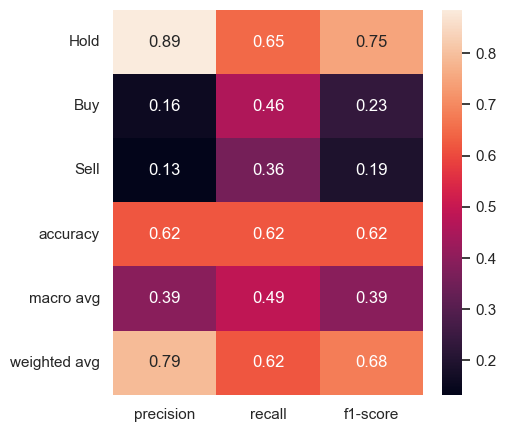

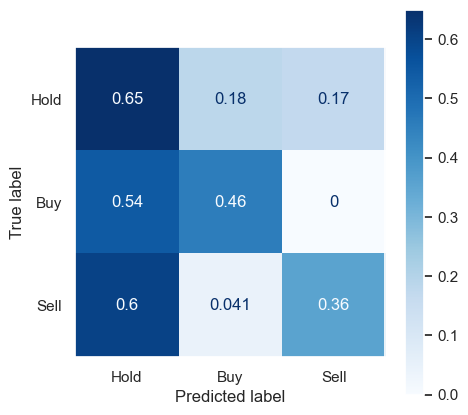

In [114]:
if RUN_MLP:
    plain_classification_report(test_labels, mlp_prediction)
    classification_report_display(test_labels, mlp_prediction)
    confusion_matrix_display(test_labels, mlp_prediction)

<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

In [115]:
if RUN_LSTM:
    plain_classification_report(test_labels, lstm_prediction)
    classification_report_display(test_labels, lstm_prediction)
    confusion_matrix_display(test_labels, lstm_prediction)

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

In [116]:
if RUN_GRU:
    plain_classification_report(test_labels, gru_prediction)
    classification_report_display(test_labels, gru_prediction)
    confusion_matrix_display(test_labels, gru_prediction)

<h1 style="font-size:30px;"> <center> CNN-2D </center> </h1>

In [117]:
if RUN_CNN:    
    plain_classification_report(test_labels, cnn2d_prediction)
    classification_report_display(test_labels, cnn2d_prediction)
    confusion_matrix_display(test_labels, cnn2d_prediction)

<h1 style="font-size:40px;"> <center> FINANCIAL EVALUATION </center> </h1>

In [118]:
test_prices = prices.loc[test_indices]
test_prices

Open        High         Low       Close  \
Date                                                                        
2015-01-13 00:00:00-05:00  176.331909  177.506760  173.213348  174.569626   
2015-01-14 00:00:00-05:00  172.470474  173.723099  171.537521  173.515762   
2015-01-15 00:00:00-05:00  174.180908  174.509171  171.805283  171.926224   
2015-01-16 00:00:00-05:00  171.710297  174.345093  171.520248  174.180954   
2015-01-20 00:00:00-05:00  174.846085  175.122528  172.919662  174.552368   
...                               ...         ...         ...         ...   
2022-12-15 00:00:00-05:00  392.497650  393.443298  386.116974  387.848999   
2022-12-16 00:00:00-05:00  385.179993  386.579987  381.040009  383.269989   
2022-12-19 00:00:00-05:00  383.470001  383.820007  378.279999  380.019989   
2022-12-20 00:00:00-05:00  379.230011  382.230011  377.850006  380.540009   
2022-12-21 00:00:00-05:00  383.250000  387.410004  382.690002  386.230011   

                              Volume  
Date                                  
2015-01-13 00:00:00-05:00  214553300  
2015-01-14 00:00:00-05:00  192991100  
2015-01-15 00:00:00-05:00  176613900  
2015-01-16 00:00:00-05:00  211879600  
2015-01-20 00:00:00-05:00  130991100  
...                              ...  
2022-12-15 00:00:00-05:00  117705900  
2022-12-16 00:00:00-05:00  119858000  
2022-12-19 00:00:00-05:00   79878100  
2022-12-20 00:00:00-05:00   74427200  
2022-12-21 00:00:00-05:00   78167400  

[1945 rows x 5 columns]

In [119]:
configurations = {
    "ticker": TICKER,
    "benchmark_ticker": BENCHMARK_TICKER,
    "ohlcv": test_prices,
    "risk_free_rate": 0.05 / 252,
    "initial_capital": 1000,
    "commission": 1,
    "alpha": 0.05,
    "threshold": 0,
    "order": 1,
    "order_type": "market",  # "market" or "limit"
    "short": False,
    "short_fee": 1,
    "standard_take_profit": False,
    "trailing_take_profit": False,
    "take_profit_ratio": 100,
    "standard_stop_loss": False,
    "trailing_stop_loss": False,
    "stop_loss_ratio": 100,
    "leverage": 1,
    "miss_rate": 10,
    "show_initial_configuration": True,
    "show_tables": True,
    "show_charts": True,
    "show_time": True,
    "precision_point": 3,
}

<h1 style="font-size:30px;"> <center> Buy & Hold </center> </h1>

In [120]:
if RUN_BUY_AND_HOLD:
    configurations["predictions"] = buy_and_hold_prediction
    metrics = financial_evaluation(**configurations)

<h1 style="font-size:30px;"> <center> Random Prediction </center> </h1>

In [121]:
if RUN_RANDOM_PREDICTION:
    configurations["predictions"] = random_prediction
    metrics = financial_evaluation(**configurations)

<h1 style="font-size:30px;"> <center> RSI </center> </h1>

In [122]:
if RUN_RSI:
    configurations["predictions"] = rsi_prediction
    metrics = financial_evaluation(**configurations)

<h1 style="font-size:30px;"> <center> EMA Crossover </center> </h1>

In [123]:
if RUN_EMA_CROSSOVER:
    configurations["predictions"] = ema_crossover_prediction
    metrics = financial_evaluation(**configurations)

<h1 style="font-size:30px;"> <center> Bollinger Bands </center> </h1>

In [124]:
if RUN_BOLLINGER_BANDS:
    configurations["predictions"] = bollinger_bands_prediction
    metrics = financial_evaluation(**configurations)

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [125]:
if RUN_MLP:
    configurations["predictions"] = mlp_prediction
    metrics = financial_evaluation(**configurations)


Backtest was completed in 0 minutes and 0.56 seconds.



<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

In [126]:
if RUN_LSTM: 
    configurations["predictions"] = lstm_prediction
    metrics = financial_evaluation(**configurations)

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

In [127]:
if RUN_GRU:
    configurations["predictions"] = gru_prediction
    metrics = financial_evaluation(**configurations)

<h1 style="font-size:30px;"> <center> CNN </center> </h1>

In [128]:
if RUN_CNN:
    configurations["predictions"] = cnn2d_prediction
    metrics = financial_evaluation(**configurations)

In [129]:
notebook_end_time = time.time()
print(f"Notebook run in {round(int(notebook_end_time - notebook_start_time) / 60, 2)} minutes")

Notebook run in 29.85 minutes
